In [118]:
# Pandas and numpy for analysing and preparing data
import pandas as pd
from pandas.io.json import json_normalize
pd.set_option('display.max_columns', None) # display all columns of a df inline
pd.set_option('display.max_rows', None) # display all rows of a df inline
import numpy as np

# Matplotlib colors
import matplotlib.cm as cm
import matplotlib.colors as colors

# Handling URL queries
import json
import requests

# Folium and geopy handle and display geospatial data
import folium # display data on interactive map
from geopy.geocoders import Nominatim # get langitude and longitude for an address

# Import BeautifulSoup for scraping table from wiki-page
from bs4 import BeautifulSoup

# To cluster neighborhoods
from sklearn.cluster import KMeans

# Read environment variables with foursquare API credentials
import os

#### Get list of Postal Codes and corresponding neighborhoods

https://www.dasoertliche.de is an online version of a telephone book for germany and also provides tables for postal codes and corresponding neighborhoods. Thus I will scrape the list with Beautiful Soup 4 from the webpage.

In [12]:
website_url = 'https://www.dasoertliche.de/Themen/Postleitzahlen/D%C3%BCsseldorf.html' # define web url
html_content = requests.get(website_url).text # download html flatfile from webpage
soup = BeautifulSoup(html_content, 'lxml') # create parse tree object
print(soup.prettify()) # display html data with indents

<!DOCTYPE html>
<html lang="de">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, user-scalable=yes" name="viewport"/>
  <script>
   var kameleoonURL = "https://35ax3z5b4g.kameleoon.eu";
	var kameleoonStartLoadTime = new Date().getTime();
	var kameleoonLoadingTimeout = 750;
	var kameleoonProcessMessageEvent = function (event) {
		if (kameleoonURL == event.origin) {
			window.removeEventListener("message", kameleoonProcessMessageEvent);
			window.kameleoonExternalIFrameLoaded = true;
			eval(event.data);
			Kameleoon.Analyst.load();
		}
	};
	if (window.addEventListener) {
		window.addEventListener("message", kameleoonProcessMessageEvent, false);
	}
	if (!document.getElementById("kameleoonLoadingStyleSheet") && !window.kameleoonDisplayPageTimeOut) {
		var kameleoonS = document.getElementsByTagName("script")[0];
		var kameleoonCc = "* { visibility: hidden !important; background-image: none !important; }";
		var kameleoonStn = document.createElement("style");
		kamele

In [13]:
# extract table and store in variable 'table'
table = soup.find('table',{'id':'tl-plz'})

In [14]:
table_headers_orig = [th.text for th in table.find_all('th')]
table_headers_orig

['PLZ', 'Ortsname', 'Ortsteil', 'Landkreis', 'Bundesland']

Manual translation of the table headers is required, as 'Das Oertliche' provides the data in german only.<br>
I am using a dictionary to raise an exception in case the query returns changed table headers.

In [15]:
translation = {'PLZ': 'Postal Code',
               'Ortsname': 'City',
               'Ortsteil': 'Neighborhood',
               'Landkreis': 'District',
               'Bundesland': 'State'
              }

table_headers = [translation[x] for x in table_headers_orig]
table_headers

['Postal Code', 'City', 'Neighborhood', 'District', 'State']

In [16]:
# Get all the rows of the table and store them as a list in table_rows
table_rows = []
for tr in table.find_all('tr')[1:]: # select all table rows, but exclude first row, as it contains headers
    table_rows.append([td.get_text(separator=', ') for td in tr.find_all('td')])

Create DataFrame with respective data for further analysis and processing.

In [17]:
dus_neighborhoods_orig = pd.DataFrame(columns=table_headers, data=table_rows)
dus_neighborhoods_orig.head()

Postal Code        City                                       Neighborhood  \
0       40210  Düsseldorf                         Friedrichstadt, Stadtmitte   
1       40211  Düsseldorf                             Pempelfort, Stadtmitte   
2       40212  Düsseldorf                         Friedrichstadt, Stadtmitte   
3       40213  Düsseldorf  Altstadt, Carlstadt, Friedrichstadt, Pempelfor...   
4       40215  Düsseldorf                                     Friedrichstadt   

           District                State  
0  Stadt Düsseldorf  Nordrhein-Westfalen  
1  Stadt Düsseldorf  Nordrhein-Westfalen  
2  Stadt Düsseldorf  Nordrhein-Westfalen  
3  Stadt Düsseldorf  Nordrhein-Westfalen  
4  Stadt Düsseldorf  Nordrhein-Westfalen

Check, the unique counts of all columns, specifically if columns 'City', 'District' and 'State' include multiple values.

In [18]:
dus_neighborhoods_orig.describe()

Postal Code        City                     Neighborhood  \
count           39          39                               39   
unique          37           1                               37   
top          40597  Düsseldorf  Derendorf, Golzheim, Pempelfort   
freq             2          39                                2   

                District                State  
count                 39                   39  
unique                 1                    1  
top     Stadt Düsseldorf  Nordrhein-Westfalen  
freq                  39                   39

As expected, columns 'City', 'District' and 'State' only include one unique value and can therefore be dropped for further processing as they do not provide additional information.<br>
<br>
Column 'Postal Code' should only include unique values, but includes minimum one duplicate entry. This needs to be further analysed and cleaned.

In [19]:
dus_neighborhoods_orig[dus_neighborhoods_orig['Postal Code'].duplicated(keep=False)]

Postal Code        City                                       Neighborhood  \
24       40489  Düsseldorf  Angermund, Kaiserswerth, Kalkum, Lohausen, Wit...   
32       40597  Düsseldorf                        Benrath, Hassels, Urdenbach   
37       40489  Düsseldorf                                           Duisburg   
38       40597  Düsseldorf                                             Hilden   

            District                State  
24  Stadt Düsseldorf  Nordrhein-Westfalen  
32  Stadt Düsseldorf  Nordrhein-Westfalen  
37  Stadt Düsseldorf  Nordrhein-Westfalen  
38  Stadt Düsseldorf  Nordrhein-Westfalen

Rows 37 and 38 needs to be dropped from the data. Duisburg and Hilden are separate cities next to Duesseldorf and I will only consider the Neighborhood names of Duesseldorf itself.

Implement decided changes to DataFrame.

In [20]:
dus_neighborhoods = (dus_neighborhoods_orig.drop(['City','District','State'], axis=1) # Drop not required columns
                                           .drop([37,38], axis=0) # Drop entries with Neighborhood not in Duesseldorf
                    )
print(dus_neighborhoods.shape)
dus_neighborhoods.head()

(37, 2)


Postal Code                                       Neighborhood
0       40210                         Friedrichstadt, Stadtmitte
1       40211                             Pempelfort, Stadtmitte
2       40212                         Friedrichstadt, Stadtmitte
3       40213  Altstadt, Carlstadt, Friedrichstadt, Pempelfor...
4       40215                                     Friedrichstadt

#### Get GeoJSON describing boundaries for all Postal Codes

https://public.opendatasoft.com provides the GeoJSON for all Postal Codes in Duesseldorf.

In [12]:
# Download GeoJSON and save as 'dus_postal_code_geo.json'
!wget --quiet 'https://public.opendatasoft.com/explore/dataset/postleitzahlen-deutschland/download/?format=geojson&refine.note=D%C3%BCsseldorf&timezone=Europe/Berlin' -O dus_postal_code_geo.json

#### Extract coordinates for centres of each postal code

Extract coordinates from GeoJSON file.

In [21]:
with open('dus_postal_code_geo.json', 'r') as f:
    json_decode = json.load(f)

coordinates = [{'Postal Code': item['properties']['plz'],
                'Latitude': item['properties']['geo_point_2d'][0],
                'Longitude': item['properties']['geo_point_2d'][1]}
               for item in json_decode['features']
              ]

coordinates = pd.DataFrame(coordinates)
print(coordinates.shape)
coordinates.head()

(38, 3)


Postal Code   Latitude  Longitude
0       40545  51.228745   6.755865
1       40211  51.229275   6.791872
2       40215  51.214431   6.783990
3       40595  51.139755   6.903908
4       40472  51.269844   6.822821

This DataFrame has one more entry than the neighborhood table. Therefore I check for duplicate postal codes.

In [24]:
print('Duplicates:')
coordinates[coordinates['Postal Code'].duplicated(keep=False)]

Duplicates:


Postal Code   Latitude  Longitude
1        40211  51.229275   6.791872
33       40211  51.223374   6.796525

At this point in time I decide to leave the duplicates in and to decide potential deletion of one entry after visualizing the areas on a map.

Merge neighborhood and centre coordinate per postal code in one DataFrame.

In [25]:
dus_data = dus_neighborhoods.merge(coordinates, how='left', on='Postal Code')
print(dus_data.shape)
dus_data.head()

(38, 4)


Postal Code                                       Neighborhood   Latitude  \
0       40210                         Friedrichstadt, Stadtmitte  51.221510   
1       40211                             Pempelfort, Stadtmitte  51.229275   
2       40211                             Pempelfort, Stadtmitte  51.223374   
3       40212                         Friedrichstadt, Stadtmitte  51.223868   
4       40213  Altstadt, Carlstadt, Friedrichstadt, Pempelfor...  51.224420   

   Longitude  
0   6.789388  
1   6.791872  
2   6.796525  
3   6.781383  
4   6.772573

In [26]:
dus_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 4 columns):
Postal Code     38 non-null object
Neighborhood    38 non-null object
Latitude        38 non-null float64
Longitude       38 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.5+ KB


No null-values in the DataFrame. No further processing needed at this point in time.

#### Visualize data on a map

In [27]:
dus_centre = Nominatim(user_agent='dus')
location = dus_centre.geocode(query='Düsseldorf', country_codes='de')
dus_latitude = location.latitude
dus_longitude = location.longitude

print(f'The coordinates of Duesseldorf are {dus_latitude}, {dus_longitude}.')

The coordinates of Duesseldorf are 51.2254018, 6.7763137.


In [116]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
    folium.Marker(location=[lat, lng],
                  icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
                 ).add_to(map_dus)
    
# generate choropleth map to show postal code areas
folium.GeoJson(data='dus_postal_code_geo.json',
              ).add_to(map_dus)

map_dus

Analyse the duplicate postal codes for 40211

In [117]:
# create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

dus_data_dupl = dus_data[dus_data['Postal Code'].duplicated(keep=False)]

for code, lat, lng in zip(dus_data_dupl.index, dus_data_dupl['Latitude'], dus_data_dupl['Longitude']):
    folium.Marker(location=[lat, lng],
                  icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
                 ).add_to(map_dus)
    
# generate choropleth map to show postal code areas
folium.GeoJson(data='dus_postal_code_geo.json',
              ).add_to(map_dus)

map_dus

Entry with index 2 in the overview is a very small area. I will keep entry at index 1 and drop index 2.

In [30]:
dus_data = dus_data.drop(2, axis=0).reset_index(drop=True)

In [31]:
dus_data.shape

(37, 4)

In [101]:
# Build one DataFrame with top venues per neighborhood
def getNearbyVenues(postal_codes, names, latitudes, longitudes, radius=500):
    
    venues_list = []
    # Iterate through list of neighborhoods
    for postal_code, name, lat, lng in zip(postal_codes, names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(client_id=os.getenv('FS_CLIENT_ID'),
                      client_secret=os.getenv('FS_CLIENT_SECRET'),
                      v='20180323',
                      ll=f'{lat},{lng}',
                      radius=radius,
                      limit=100
                     )

        # make the GET request
        results = requests.get(url=url, params=params).json()
        try:
            results = results['response']['groups'][0]['items']

        except:
            print('Something went wrong with the query. Here are some information:')
            print(f'Postal Code: {postal_code}, Section: {section}')
            print(results)
        # List of list with only relevant information per venue
        # Multiple entries per venue, if multiple categories have been assigned
        for v in results: 
            venues_list.append([(postal_code,
                                 name,
                                 lat,
                                 lng,
                                 v['venue']['name'],
                                 v['venue']['location']['lat'],
                                 v['venue']['location']['lng'],
                                 n['name']) for n in v['venue']['categories']]
                              )

        # Create DataFrame
        columns = ['Postal Code', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude',
                   'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = columns
    
    return(nearby_venues)

In [102]:
# Create DataFrame with one row per venue returned matching the neighborhood it belongs to 
dus_venues = getNearbyVenues(postal_codes=dus_data['Postal Code'],
                             names=dus_data['Neighborhood'],
                             latitudes=dus_data['Latitude'],
                             longitudes=dus_data['Longitude']
                            )

In [103]:
dus_venues.head()

Postal Code                Neighborhood  Neighborhood Latitude  \
0       40210  Friedrichstadt, Stadtmitte               51.22151   
1       40210  Friedrichstadt, Stadtmitte               51.22151   
2       40210  Friedrichstadt, Stadtmitte               51.22151   
3       40210  Friedrichstadt, Stadtmitte               51.22151   
4       40210  Friedrichstadt, Stadtmitte               51.22151   

   Neighborhood Longitude               Venue  Venue Latitude  \
0                6.789388        Hanaro Markt       51.222006   
1                6.789388  Kushi Tei of Tokyo       51.223275   
2                6.789388              Takumi       51.223429   
3                6.789388          Korea Haus       51.221820   
4                6.789388      Grill House 56       51.222084   

   Venue Longitude       Venue Category  
0         6.788910        Grocery Store  
1         6.789558  Japanese Restaurant  
2         6.788531     Ramen Restaurant  
3         6.787069    Korean Restaurant  
4         6.786261        Souvlaki Shop

In [31]:
dus_venues.to_pickle('dus_venues.pkl', compression="gzip")

In [106]:
venue_counts = (dus_venues['Postal Code'].value_counts()
                                        .to_frame()
                                        .reset_index(drop=False)
                                        .rename(columns={'index':'Postal Code', 'Postal Code':'Venues'})
               )
venue_counts

Postal Code  Venues
0        40213     100
1        40212     100
2        40210     100
3        40219      78
4        40215      78
5        40217      65
6        40477      49
7        40211      47
8        40479      45
9        40476      43
10       40233      30
11       40545      27
12       40227      24
13       40597      23
14       40239      17
15       40223      13
16       40591      11
17       40547      10
18       40470      10
19       40549       9
20       40229       8
21       40235       8
22       40599       6
23       40474       6
24       40468       6
25       40625       6
26       40231       5
27       40225       4
28       40472       3
29       40589       3
30       40221       2
31       40489       2
32       40237       2
33       40627       2
34       40595       2

For 35 of the 37 postal code areas, min. one venue has been returned.

In [115]:
len(dus_venues['Postal Code'].value_counts())

35

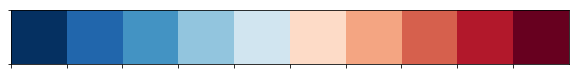

In [118]:
color_scale = np.array(['#053061','#2166ac','#4393c3','#92c5de','#d1e5f0','#fddbc7','#f4a582','#d6604d','#b2182b','#67001f'])
sns.palplot(sns.color_palette(color_scale))

In [114]:
# Create map centered on Duesseldorf
map_dus = folium.Map(location=[dus_latitude, dus_longitude],
                     zoom_start=11,
                     min_zoom=10,
                     max_zoom=19,
                     zoom_control=False
                    )

# for code, lat, lng in zip(dus_data['Postal Code'], dus_data['Latitude'], dus_data['Longitude']):
#     folium.Marker(location=[lat, lng],
#                   icon=folium.DivIcon(html=f"""<div style="color: black;">{code}</div>""")
#                  ).add_to(map_dus)

# Define bins for coloring
threshold_scale = list(range(0,101,20))
threshold_scale[-1] = threshold_scale[-1] + 0.1

# Generate choropleth map to show postal code areas
folium.Choropleth(
    geo_data='dus_postal_code_geo.json',
    key_on='feature.properties.plz',
    data=venue_counts,
    columns=['Postal Code', 'Venues'],
    fill_color='BuGn',
    threshold_scale=threshold_scale,
    fill_opacity=0.7, 
    line_opacity=0.5,
    legend_name='Venues per Postal Code'
).add_to(map_dus)

map_dus

In [130]:
dus_venues_one_hot = pd.get_dummies(dus_venues[['Postal Code', 'Venue Category']], columns=['Venue Category'])

Postal Code  Venue Category_Advertising Agency  \
0       40210                                  0   
1       40210                                  0   
2       40210                                  0   
3       40210                                  0   
4       40210                                  0   

   Venue Category_Airport Terminal  Venue Category_American Restaurant  \
0                                0                                   0   
1                                0                                   0   
2                                0                                   0   
3                                0                                   0   
4                                0                                   0   

   Venue Category_Argentinian Restaurant  Venue Category_Art Gallery  \
0                                      0                           0   
1                                      0                           0   
2                                      0                           0   
3                                      0                           0   
4                                      0                           0   

   Venue Category_Art Museum  Venue Category_Arts & Crafts Store  \
0                          0                                   0   
1                          0                                   0   
2                          0                                   0   
3                          0                                   0   
4                          0                                   0   

   Venue Category_Asian Restaurant  Venue Category_Athletics & Sports  \
0                                0                                  0   
1                                0                                  0   
2                                0                                  0   
3                                0                                  0   
4                                0                                  0   

   Venue Category_Automotive Shop  Venue Category_BBQ Joint  \
0                               0                         0   
1                               0                         0   
2                               0                         0   
3                               0                         0   
4                               0                         0   

   Venue Category_Bakery  Venue Category_Bank  Venue Category_Bar  \
0                      0                    0                   0   
1                      0                    0                   0   
2                      0                    0                   0   
3                      0                    0                   0   
4                      0                    0                   0   

   Venue Category_Beach  Venue Category_Beer Bar  Venue Category_Beer Garden  \
0                     0                        0                           0   
1                     0                        0                           0   
2                     0                        0                           0   
3                     0                        0                           0   
4                     0                        0                           0   

   Venue Category_Beer Store  Venue Category_Bistro  Venue Category_Bookstore  \
0                          0                      0                         0   
1                          0                      0                         0   
2                          0                      0                         0   
3                          0                      0                         0   
4                          0                      0                         0   

   Venue Category_Boutique  Venue Category_Bowling Alley  \
0                        0                             0   
1                        0                             0   
2                    

In [134]:
dus_venues_mean = dus_venues_one_hot.groupby(by='Postal Code').agg('mean').reset_index(drop=False)

Postal Code  Venue Category_Advertising Agency  \
0       40210                           0.000000   
1       40211                           0.021277   
2       40212                           0.000000   
3       40213                           0.000000   
4       40215                           0.000000   

   Venue Category_Airport Terminal  Venue Category_American Restaurant  \
0                              0.0                                 0.0   
1                              0.0                                 0.0   
2                              0.0                                 0.0   
3                              0.0                                 0.0   
4                              0.0                                 0.0   

   Venue Category_Argentinian Restaurant  Venue Category_Art Gallery  \
0                                   0.00                    0.000000   
1                                   0.00                    0.021277   
2                                   0.00                    0.000000   
3                                   0.01                    0.000000   
4                                   0.00                    0.012821   

   Venue Category_Art Museum  Venue Category_Arts & Crafts Store  \
0                        0.0                                0.01   
1                        0.0                                0.00   
2                        0.0                                0.01   
3                        0.0                                0.00   
4                        0.0                                0.00   

   Venue Category_Asian Restaurant  Venue Category_Athletics & Sports  \
0                              0.0                                0.0   
1                              0.0                                0.0   
2                              0.0                                0.0   
3                              0.0                                0.0   
4                              0.0                                0.0   

   Venue Category_Automotive Shop  Venue Category_BBQ Joint  \
0                             0.0                  0.000000   
1                             0.0                  0.000000   
2                             0.0                  0.000000   
3                             0.0                  0.020000   
4                             0.0                  0.012821   

   Venue Category_Bakery  Venue Category_Bank  Venue Category_Bar  \
0               0.030000                  0.0            0.010000   
1               0.000000                  0.0            0.000000   
2               0.030000                  0.0            0.000000   
3               0.020000                  0.0            0.050000   
4               0.064103                  0.0            0.064103   

   Venue Category_Beach  Venue Category_Beer Bar  Venue Category_Beer Garden  \
0                   0.0                     0.00                        0.00   
1                   0.0                     0.00                        0.00   
2                   0.0                     0.00                        0.00   
3                   0.0                     0.01                        0.02   
4                   0.0                     0.00                        0.00   

   Venue Category_Beer Store  Venue Category_Bistro  Venue Category_Bookstore  \
0                   0.000000                   0.00                      0.01   
1                   0.000000                   0.00                      0.00   
2                   0.000000                   0.00                      0.01   
3                   0.000000                   0.01                      0.01   
4                   0.012821                   0.00                      0.00   

   Venue Category_Boutique  Venue Category_Bowling Alley  \
0                     0.00                           0.0   
1                     0.00                           0.0   
2                    